# Open the [Readme.ipynb](Readme.ipynb) with outputs rendered by github 
# pandas-ml-qunat - The Pandas Machine Leraning and Quant Finance Library

This is the root repository of the follwoing 3 core components:

* pandas-ml-common - a more general utilities and monkey patched pandas objects provider
* pandas-ml-quant - provides technical analysis inidcators, plots, loss functions, etc.
* pandas-ml-utils - apply statistical or ml models directly to data frames

## Demonstration of all 3 libraries used together
### First import needed objects

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_quant import pd, np

automatically imported pandas_ml_utils 0.1.0


### Next fetch some stock data and plot it

Note that:
1. all indicators and charting functionalities are behind the **q**and property attached to all pandas objects
1. the **m**achine**l**earning proptery provides access to (raw) data as it is useful/needed by statistical and ml models
1. all model relevant functionalities are behind the **model** property


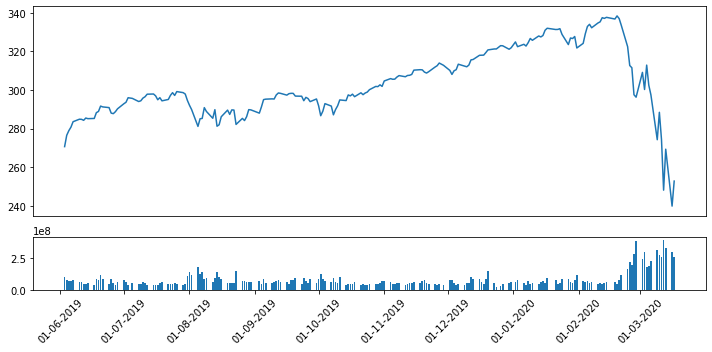

In [2]:
df = pd.fetch_yahoo("SPY").loc[:'2020-03-17']

# NOTE the access to the q_uant property
df[-200:].q.ta_plot(figsize=(10, 5))()

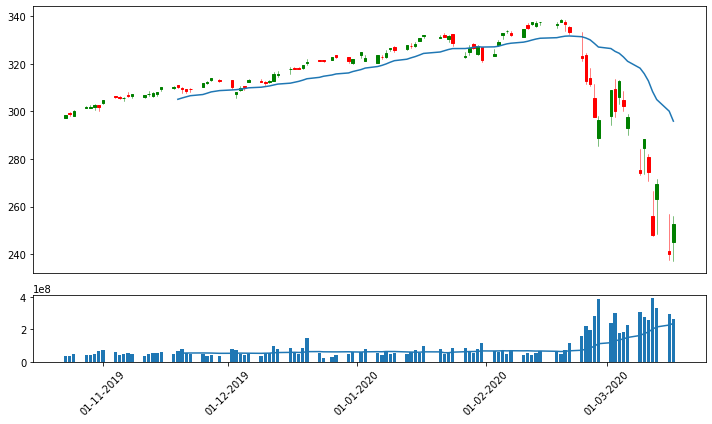

In [3]:
plt = df[-100:].q.ta_plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].q.ta_sma(period=20))
plt.bar("Volume")
plt.line(df[-100:]["Volume"].q.ta_sma(period=20), panel=1)

### Next think of a predictive model
Lets say we want to predict in which quantile of a bolliner bands indicator the price in the future will be:
* 0 means below lower band
* 1 means in the middle band
* 2 means above the upper band


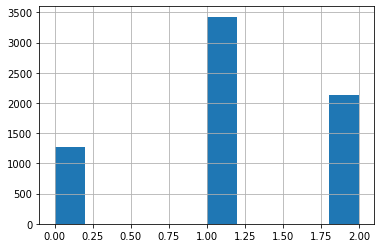

In [4]:
# NOTE all technical analysis starts with the "ta_" prefix
df["Close"].q.ta_future_bband_quantile(5, 5).hist()

And we want to predict this event based on a set of indicators like the RSI (Relative Strength Index) and such.

So we can build up a features and labels definition like so:

In [6]:
fnl = FeaturesAndLabels(
    features=[
        lambda df: df["Close"].q.ta_macd(),
        lambda df: df["Close"].q.ta_apo(),
        lambda df: df["Close"].q.ta_rsi(),
        lambda df: df["Close"].q.ta_roc(),
        lambda df: df["Close"].q.ta_trix(),
        lambda df: df["Close"].q.ta_ppo(),
        lambda df: df["Close"].pct_change().q.ta_zscore() / 4.,
        lambda df: df["Close"].q.ta_week_day(),
        lambda df: df["Close"].q.ta_week(),
        lambda df: df["Close"].q.ta_up_down_volatility_ratio(),
        lambda df: df.q.ta_adx(), 
        lambda df: df.q.ta_atr(),
        lambda df: df.q.ta_tr(),
        lambda df: df.q.ta_williams_R(),
        lambda df: df.q.ta_ultimate_osc(),
        lambda df: df.q.ta_bop(),
        lambda df: df.q.ta_cci(),
    ],
    labels=[
        lambda df: df["Close"].q.ta_future_bband_quantile(5, 5)
    ]
)

# NOTE the df.ml property provides access to (raw) data as it is useful/needed by statistical models
(features, req_samples), labels, targets, weights = df.ml.extract(fnl)
features.describe()

  res = df.rolling(period).apply(lambda c: zscore(c, ddof=ddof)[-1])

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



,"macd_12,26,9","signal_12,26,9","histogram_12,26,9","Close_apo_12,26,0",Close_rsi_14,Close_roc_10,Close_trix_30,"Close_ppo_12,26,1",Close_z_20,dow,...,-DM,+DI,-DI,ADX,atr_14,true_range,williams_R_14,"ultimate_osc_7,14,28",bop,cci_14
count,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,...,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000
mean,0.002469,0.002483,-0.000013,1.002586,0.549427,0.004074,0.036966,0.002469,-0.007533,0.336768,...,0.003463,0.002995,0.002842,0.231508,1.485172,1.503834,0.377476,0.546888,0.035811,0.240851
std,0.010855,0.010182,0.003328,0.015171,0.113741,0.031286,0.104873,0.010855,0.246222,0.233431,...,0.002748,0.002434,0.002135,0.083869,0.919671,1.321177,0.301250,0.101891,0.535373,1.052064
min,-0.074439,-0.067679,-0.026184,0.891753,0.167987,-0.267695,-0.558651,-0.074439,-0.972346,0.000000,...,0.000385,0.000195,0.000205,0.076091,0.147346,0.040000,0.000000,0.213749,-1.000000,-3.522097
25%,-0.002274,-0.001854,-0.001825,0.995358,0.468815,-0.010741,-0.004669,-0.002274,-0.159941,0.166667,...,0.001728,0.001474,0.001469,0.168649,0.906482,0.750000,0.104874,0.475120,-0.418288,-0.566424
50%,0.004365,0.004193,-0.000021,1.004712,0.557348,0.006628,0.053200,0.004365,-0.008143,0.333333,...,0.002671,0.002294,0.002271,0.217138,1.332388,1.200000,0.306414,0.550509,0.053452,0.465164
75%,0.009254,0.008946,0.001737,1.011826,0.634104,0.021492,0.100349,0.009254,0.153027,0.500000,...,0.004235,0.003372,0.003374,0.278844,1.845394,1.850000,0.627805,0.621086,0.500000,1.055129
max,0.030255,0.026989,0.018455,1.059521,0.872283,0.215963,0.248463,0.030255,0.839008,0.666667,...,0.027597,0.015448,0.017921,0.590979,9.783421,24.010000,1.000000,0.846781,1.000000,3.215749


Since we have no idea which features are actually "good" to predict the label, we want to do some feature analysis fist.


  res = df.rolling(period).apply(lambda c: zscore(c, ddof=ddof)[-1])

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



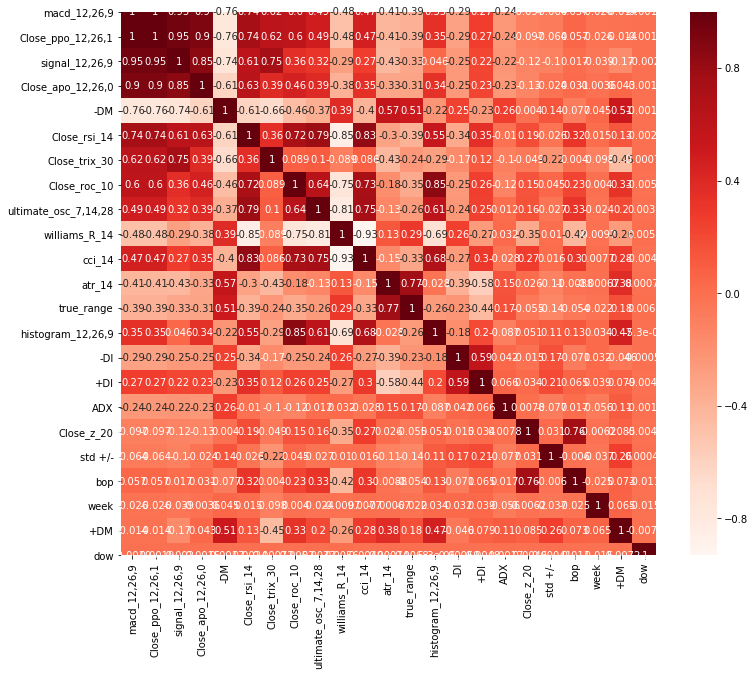

  forest.fit(x, y)



              macd_12,26,9  Close_ppo_12,26,1  signal_12,26,9  \
macd_12,26,9           1.0                1.0        0.951951   

              Close_apo_12,26,0       -DM  Close_rsi_14  Close_trix_30  \
macd_12,26,9           0.904932 -0.758319      0.744867       0.618251   

              Close_roc_10  ultimate_osc_7,14,28  williams_R_14  ...  \
macd_12,26,9      0.598308              0.489702      -0.482678  ...   

              histogram_12,26,9       -DI       +DI     ADX  Close_z_20  \
macd_12,26,9           0.349427 -0.292012  0.267124 -0.2365   -0.096875   

               std +/-       bop      week       +DM       dow  
macd_12,26,9 -0.063757  0.056586 -0.025913 -0.014462 -0.001894  

[1 rows x 23 columns]
label is continuous: True


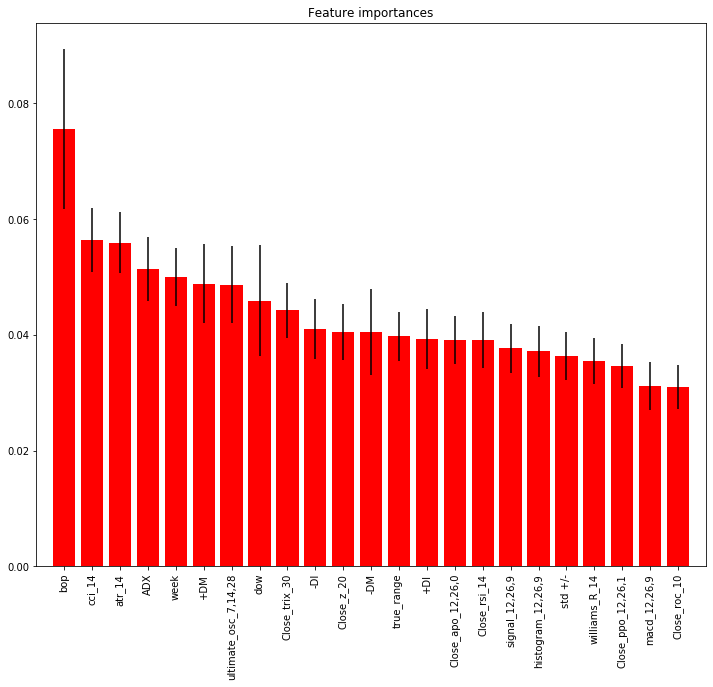

Feature ranking:
['bop', 'cci_14', 'atr_14', 'ADX', 'week', '+DM', 'ultimate_osc_7,14,28', 'dow', 'Close_trix_30', '-DI', 'Close_z_20', '-DM', 'true_range', '+DI', 'Close_apo_12,26,0', 'Close_rsi_14', 'signal_12,26,9', 'histogram_12,26,9', 'std +/-', 'williams_R_14', 'Close_ppo_12,26,1', 'macd_12,26,9', 'Close_roc_10']

TOP 5 features
     bop    cci_14    atr_14       ADX      week
bop  1.0  0.302767 -0.008787  0.016897 -0.024606
Features after correlation filer:
                   bop    cci_14      week     ADX    atr_14
macd_12,26,9  0.056586  0.465269 -0.025913 -0.2365 -0.414041


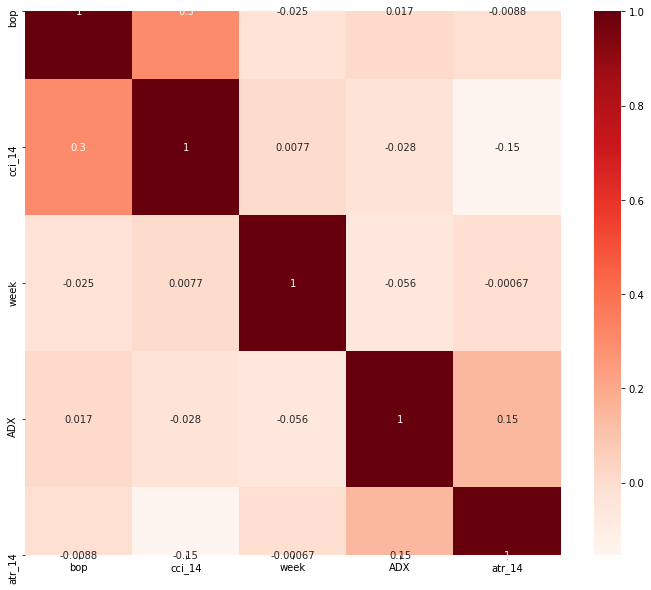

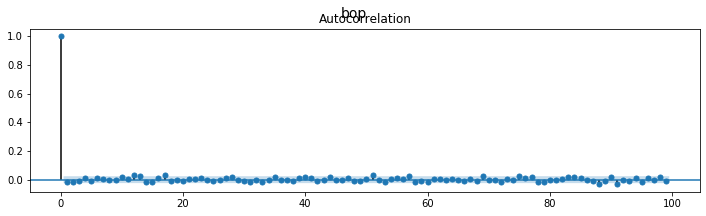

bop       1.000000
bop_0     1.000000
bop_51    0.034060
bop_17    0.031661
bop_12    0.030729
bop_75    0.025312
bop_57    0.024116
bop_69    0.022952
bop_13    0.022301
bop_84    0.021370
Name: bop, dtype: float64


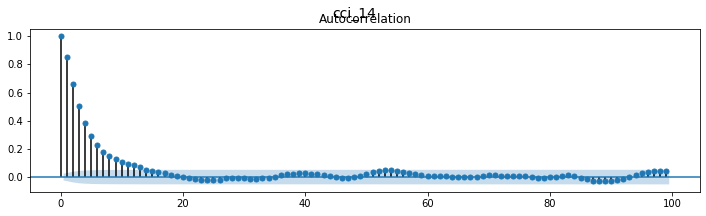

cci_14      1.000000
cci_14_0    1.000000
cci_14_1    0.850305
cci_14_2    0.660462
cci_14_3    0.505893
cci_14_4    0.384720
cci_14_5    0.290350
cci_14_6    0.225086
cci_14_7    0.181065
cci_14_8    0.149521
Name: cci_14, dtype: float64


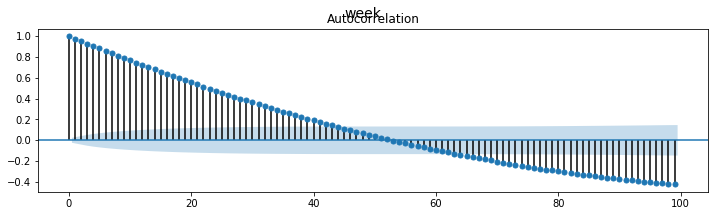

week      1.000000
week_0    1.000000
week_1    0.976207
week_2    0.952410
week_3    0.928608
week_4    0.904835
week_5    0.882347
week_6    0.859476
week_7    0.836600
week_8    0.813717
Name: week, dtype: float64


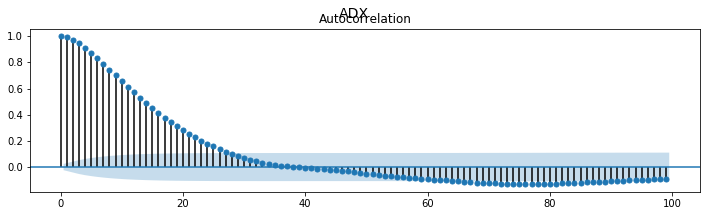

ADX      1.000000
ADX_0    1.000000
ADX_1    0.992803
ADX_2    0.974022
ADX_3    0.946700
ADX_4    0.913083
ADX_5    0.875012
ADX_6    0.833952
ADX_7    0.790988
ADX_8    0.746915
Name: ADX, dtype: float64


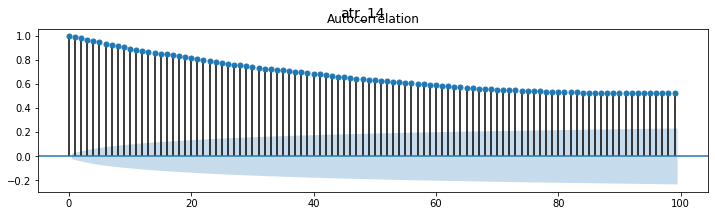

atr_14      1.000000
atr_14_0    1.000000
atr_14_1    0.997503
atr_14_2    0.993207
atr_14_3    0.987476
atr_14_4    0.980510
atr_14_5    0.972555
atr_14_6    0.963899
atr_14_7    0.954901
atr_14_8    0.945777
Name: atr_14, dtype: float64
best lags are
[(1, '-1.00'), (2, '-0.76'), (3, '-0.71'), (4, '-0.67'), (5, '-0.64'), (6, '-0.60'), (7, '-0.58'), (8, '-0.55'), (9, '-0.53'), (10, '-0.51'), (11, '-0.50'), (12, '-0.48'), (13, '-0.46'), (14, '-0.45'), (15, '-0.42'), (16, '-0.40'), (17, '-0.40'), (18, '-0.39'), (19, '-0.36'), (20, '-0.35'), (21, '-0.34'), (22, '-0.33'), (23, '-0.31'), (24, '-0.30'), (25, '-0.29'), (26, '-0.28'), (27, '-0.27'), (28, '-0.27'), (29, '-0.26'), (30, '-0.25'), (31, '-0.24'), (32, '-0.23'), (33, '-0.22'), (34, '-0.22'), (36, '-0.21'), (35, '-0.21'), (37, '-0.20'), (38, '-0.20'), (40, '-0.19'), (39, '-0.19'), (41, '-0.19'), (42, '-0.18'), (43, '-0.17'), (44, '-0.17'), (45, '-0.17'), (46, '-0.16'), (47, '-0.15'), (48, '-0.15'), (52, '-0.14'), (49, '-0.14'), (51, 

In [7]:
features, lags = df.model.feature_selection(fnl)

In [8]:
features

['bop', 'cci_14', 'atr_14', 'ADX', 'week']

Looks like 'cci_14', 'atr_14', 'Close_trix_30', 'ADX', 'Close_z_20' are the top 5 features to predict the label .

So now we can build up a model from the learnings we have made.

In [12]:
from pandas_ml_utils.ml.data.sampeling import KFoldBoostRareEvents, KEquallyWeightEvents

fit = df.model.fit(
    SkModel(
        MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 50), random_state=42, alpha=2.0),
        FeaturesAndLabels(
            features=extract_with_post_processor(
                [
                    #lambda df: df["Close"].q.ta_macd(),
                    #lambda df: df["Close"].q.ta_apo(),
                    #lambda df: df["Close"].q.ta_rsi(),
                    #lambda df: df["Close"].q.ta_roc(),
                    #lambda df: df["Close"].q.ta_trix(),
                    #lambda df: df["Close"].q.ta_ppo(),
                    #lambda df: df["Close"].pct_change().q.ta_zscore() / 4.,
                    lambda df: df["Close"].q.ta_week_day(),
                    #lambda df: df["Close"].q.ta_week(),
                    #lambda df: df["Close"].q.ta_up_down_volatility_ratio(),
                    lambda df: df.q.ta_adx()[["ADX"]], 
                    lambda df: df.q.ta_atr(),
                    #lambda df: df.q.ta_tr(),
                    #lambda df: df.q.ta_williams_R(),
                    #lambda df: df.q.ta_ultimate_osc(),
                    lambda df: df.q.ta_bop(),
                    lambda df: df.q.ta_cci(),
                ],
                lambda df: df.q.ta_rnn(lags)
            ),
            labels=[
                lambda df: df["Close"].q.ta_future_bband_quantile(5, 5, stddev=2.0).q.ta_one_hot_encode_discrete()

            ],
            targets=[
                lambda df: df["Close"].q.ta_bbands(5, stddev=2.0)[["lower", "upper"]]
            ],
            min_required_samples=max(lags)+1
        ),
        summary_provider=ClassificationSummary,
    ),
    test_size=0.4, 
    test_validate_split_seed=42, 
)

fit

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



This obviously is not the besst model but you got the Idea. Also not the quite large penalization term which is "engineered" by trail and error. However One could also use the Hyperparameter optimization possibility:

```python
fit = df.model.fit(
    SkModel(...),
    test_size=0.4,
    test_validate_split_seed=42,
    hyper_parameter_space={'alpha': hp.choice('alpha', [0.0001, 10]), 'max_iter': 50,
                           '__max_evals': 4, '__rstate': np.random.RandomState(42)}
```

The leading `__` is used as a prefix for parameters passed to [hyperopt](https://github.com/hyperopt/hyperopt). All other parameters are passed to the model, like `max_iter` or `alpha` are parameters for an sklearn MLClassifier.

Ok now if we want to know what the current prediction is for the next 5 days, we simply call

```python
df.model.predict(fit.model)[-1:]["prediction"]
# [[6.13729022e-06, 9.99999839e-01, 1.07792629e-08]]
```

Oh wait now we know that we expect the price to be in the middle band but what does this actually mean? Which values are the middle band?
This is where the target comes into play.

In [13]:
df.model.predict(fit.model, tail=3).map_prediction_to_target()

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



prediction
2020-03-13 (-inf, 241.7)       0.140334
           (241.7, 300.08)     0.982584
           (300.08, inf)       0.000868
2020-03-16 (-inf, 224.42)      0.062345
           (224.42, 303.61)    0.998799
           (303.61, inf)       0.000101
2020-03-17 (-inf, 227.84)      0.030550
           (227.84, 285.94)    0.999275
           (285.94, inf)       0.000112